<a href="https://colab.research.google.com/github/swoo-nam/project_final_team1/blob/main/%EC%A0%95%EC%88%98%EC%9D%B8_%EC%84%9C%EB%B9%84%EC%8A%A42%EC%9E%91%EC%97%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/data/"
SEED = 42

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [5]:
import torch
from tqdm.auto import tqdm
import random
import os

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
torch.cuda.is_available()

True

In [7]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.6 MB/s eta 0:00:00


In [8]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.16.0-py3-none-any.whl size=30813255 sha256=24d70e3bb151475a6fdda603ec4bff5e10b3270095cbc3e2a9cce29b0c5a93e9
  Stored in directory: /root/.cache/pip/wheels/6b/03/2b/ac2c97cc65ebd9df3516f4b900adc2f0a744df8d1375b2e2ef
Successfully built kiwipiepy-model


데이터 정제 및 전처리

In [54]:
rawyogiyo_df = pd.read_csv(f"{DATA_PATH}yogiyo_reviews_0905.csv")
yogiyo_df = rawyogiyo_df.copy()
yogiyo_df

,가게이름,고객리뷰,별점,맛별점,양별점,배달별점,사장댓글,메뉴
0,1988응답하라추억의옛날도시락-방이점,저도 모르게 은근 여기 자주 시켜먹고 있었네요ㅎ \n늘 잘먹고 있습니다,5,5,5,5.0,저희 메뉴 맛있죠?ㅎㅎ 이렇게 빠져 드시는 거에요>.<\n\n그냥 일로서 만드는 게...,제육옛날도시락＋김찌 정식＋（서비스）콜라
1,1988응답하라추억의옛날도시락-방이점,김치찌개 된장찌개 잡채\n다 잘먹었습니다,5,5,5,5.0,전부 잘 드셔 주셔서 감사합니다 ><\n\n좋은 시간을 드리고 싶었어요ㅠㅠ 열심히 ...,"돼지고기김치찌개＋대접밥,우삼겹된장찌개＋대접밥,오색빛깔 잡채"
2,1988응답하라추억의옛날도시락-방이점,처음시켜보는데 맛있고 리뷰서비스도 괜찮네요. 다음에도 또시킬듯요,5,5,5,5.0,안녕하세요~~! :D\n\n저희 매장을 처음 찾아주신 고객님이시네요😆 처음 방문이라...,"[불맛]제육 옛날도시락,우삼겹옛날도시락＋미니냉면＋（서비스）콜라"
3,1988응답하라추억의옛날도시락-방이점,맛있습니다! 근데 국물이 안와서 아쉽습니다..,4,4,4,3.0,안녕하세요 1988응답하라추억의옛날도시락입니다.\n\n저희 측 실수로 인하여 누락이...,양념갈비 옛날도시락
4,1988응답하라추억의옛날도시락-방이점,맛있게잘먹었습니다,5,5,5,5.0,"헤헤, gh**님! 감사해요! 😊 \n\n맛있게 드셨다니 앞으로도 더 열심히 일할게...","삼겹정찬도시락,돼지고기김치찌개＋대접밥"
...,...,...,...,...,...,...,...,...
24993,놀부 부대찌개-광주우산점,먹을만하다고느낍니다,4,3,3,3.0,놀부를 이용해 주셔서 감사합니다 ^^\n큰 만족을 드리지 못한것 같아 죄송합니다.\...,NaN
24994,놀부 부대찌개-광주우산점,조리를해야하는 불편함이 있긴했지만..매장에서 먹는맛 그대로이고 양도 엄청많네요 4인...,5,5,5,5.0,저희 놀부를 이용해 주셔서감사드립니다 ^^\n집에서 조리시에도 매장과 최대한 비슷하...,NaN
24995,놀부 부대찌개-광주우산점,오랜만에 놀부부대찌게~~~\n맛있었는더ㆍ\n햄 양을 늘리심 좋을듯,5,5,4,5.0,놀부를 이용해 주셔서 감사합니다 ^^\n맛있게 드셨다니 다행입니다.\n저희는 정해진...,NaN
24996,놀부 부대찌개-광주우산점,예전에 참전한 6.25 에서 먹은 부대찌개 맛이 나네요 맛있읍니다.,5,5,5,5.0,저희 놀부부대찌개를 맛있게 드셔주셔서 감사합니다 ^^\n어디서 드시더라도 항상 맛있...,NaN


In [55]:
rate_counts = yogiyo_df["별점"].value_counts().sort_index(ascending=False)
rate_counts

5    23802
4      771
3      227
2       87
1      111
Name: 별점, dtype: int64

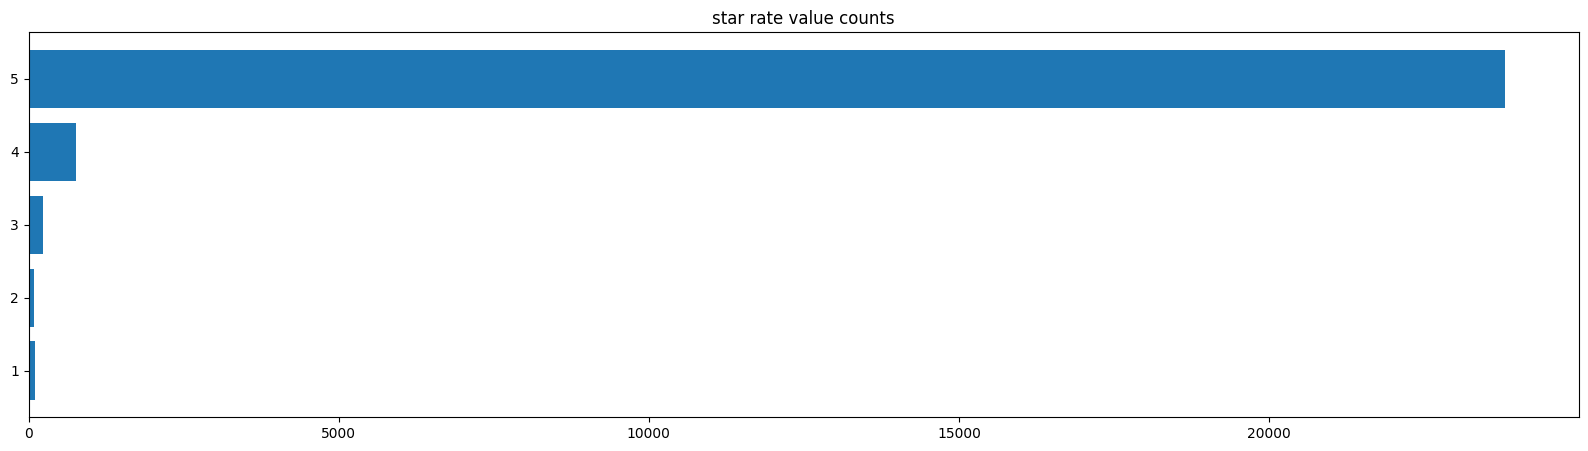

In [56]:
plt.figure(figsize=(20, 5))
plt.barh([5,4,3,2,1], rate_counts)
plt.title("star rate value counts")
plt.show()

In [12]:
delivery_rate_counts = yogiyo_df["배달별점"].value_counts().sort_index(ascending=False)
delivery_rate_counts

5.0    22593
4.0      691
3.0      250
2.0       87
1.0      185
0.0     1192
Name: 배달별점, dtype: int64

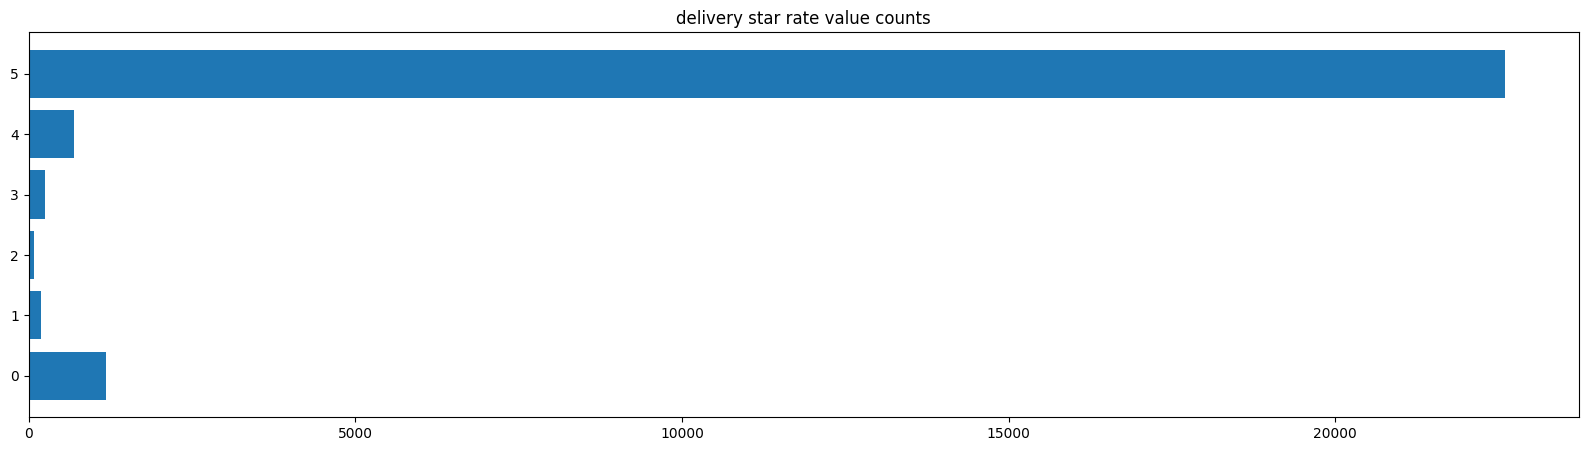

In [13]:
plt.figure(figsize=(20, 5))
plt.barh([5,4,3,2,1,0], delivery_rate_counts)
plt.title("delivery star rate value counts")
plt.show()

In [14]:
mask =  yogiyo_df["배달별점"] == 0.0
yogiyo_df.loc[mask]

,가게이름,고객리뷰,별점,맛별점,양별점,배달별점,사장댓글,메뉴
49,1988응답하라추억의옛날도시락-방이점,가성비 아주 만족 합니다.\n맛있게 잘먹었습니다.,5,5,5,0.0,즐거운 순간을 저희와 함께해주셔서 감사합니다💖\n\n믿고 찾아 주셔서 진심으로 감사...,삼겹정찬도시락
101,1988응답하라추억의옛날도시락-방이점,가성비 아주 만족 합니다.\n양많고 맛도 좋아요,5,5,5,0.0,이렇게 저희 매장 찾아주셔서 감사드립니다🙏\n\n맛있다는 말씀은 언제 들어도 설레는...,삼겹정찬도시락
191,워커스커피 로스터스,복숭아에이드 짱짱맛입니다,5,5,5,0.0,안녕하세요! 주문 감사드립니다 !저희 간판 메뉴 중 하나 입니다 ㅎㅎ 맛있게 드셨다...,[GANPAN] 구봉근에이드／막내 봉근이를 넣은 메뉴
209,워커스커피 로스터스,차에서 먹을려고 테이크아웃 했어요.\n맛있어요.,5,5,5,0.0,안녕하세요! 주문해주셔서 감사드립니다 따뜻할때 아메리카노와 함께 먹는 와플은 정말 ...,[GANPAN] 리에주와플
285,워커스커피 로스터스,또 주문했어요ㅋ\n여기 커피 최고에요ㅋ,5,5,5,0.0,칭찬해주시니 감사합니다!\n자주 찾아주세요! 항상 일정한 맛과 최고의 서비스로 보답...,"오렌지브레붸[SIGNATURE],블렌딩바닐라라떼"
...,...,...,...,...,...,...,...,...
24724,유쾌한꼬막&한끼끝판왕-광주직영점,양 푸짐하고 맛있어요,5,5,5,0.0,맛있게 드셨다니 감사합니다😊\n항상 푸짐한 양과 최고의 맛으로 \n보답 드리는 유쾌...,끝판왕양념밥
24729,유쾌한꼬막&한끼끝판왕-광주직영점,온갖 해산물 싫어하는 사람입니다. 냄새 1도 없고 맛있게 먹었습니다.,5,5,5,0.0,저희 음식에 만족해주셔서 너무 감사드립니다😊\n앞으로도 변함없는 맛으로 보답드리겠습...,끝판왕양념밥
24757,유쾌한꼬막&한끼끝판왕-광주직영점,음식은 맛있어요 그런데 깻잎이 상태가 별로네요 다음엔 신경써주세요,5,5,5,0.0,식사에 불편을 드려 죄송합니다🙏🏻😭\n말씀해주신 내용 참고해서 다음번엔 만족스러운 ...,"신선한육회비빔밥 ＋ 소고기미역국,벌교꼬막무침"
24813,놀부 부대찌개-광주우산점,육수 넉넉히 주셔서 감사합니다~^^,5,5,5,0.0,놀부를 이용해 주셔서 감사합니다.\n고객분들의 의견을 반영해 저희 매장에서는\n육수...,놀부부대 2인*


In [15]:
mask =  yogiyo_df["배달별점"] == 1.0
yogiyo_df.loc[mask]

,가게이름,고객리뷰,별점,맛별점,양별점,배달별점,사장댓글,메뉴
65,1988응답하라추억의옛날도시락-방이점,20분 이내 배달 알림 주시고는 한시간이 지나서야 받았습니다. 배달이 늦는 점에 대...,2,4,4,1.0,안녕하세요 1988응답하라추억의옛날도시락 입니다.\n\n남겨 주신 리뷰 잘 읽어보았...,"스팸옛날도시락＋미니냉면＋（서비스）콜라,제육옛날도시락＋김찌 정식＋（서비스）콜라"
85,1988응답하라추억의옛날도시락-방이점,맛이나 양은 무난해요\n그런데...\n배달예정시간이 무색하게 늦게도착ㅜㅜ\n차라리 ...,3,3,4,1.0,1988응답하라추억의옛날도시락을 선택해 주셔서 감사합니다. \n\n저희 매장에서는 ...,제육정찬도시락
93,1988응답하라추억의옛날도시락-방이점,예정시간보다 30분이 지나서야 도착하고 음식도 다 식어서 왔네요,3,3,4,1.0,1988응답하라추억의옛날도시락을 선택해 주셔서 감사합니다. \n\n저희 매장에서는 ...,"제육옛날도시락＋김찌 정식＋（서비스）콜라,엄마가 해주는 계란후라이,비빔장"
99,1988응답하라추억의옛날도시락-방이점,배달 늦게옴 \n전화주면 받으러나간다니깐 전화 안줌,2,3,3,1.0,저희 1988응답하라추억의옛날도시락을 찾아 주셔서 감사합니다. \n\n맛있게 드시는...,삼겹옛날도시락＋미니냉면＋（서비스）콜라
138,1988응답하라추억의옛날도시락-방이점,리뷰 이벤트 한다지만 너무 아닌 거 같아서 적습니다. 배달이 20분 넘게 안오길래 ...,1,1,1,1.0,안녕하세요 1988응답하라추억의옛날도시락 입니다.\n\n주신 리뷰 잘 읽었습니다. ...,[강추]우삼겹옛날도시락
...,...,...,...,...,...,...,...,...
24169,빕스얌딜리버리-광주광천점,"일회용수저, 포크가 필요하다고 체크했는데ㅠㅠ안챙겨주셨네요ㅠㅠ",3,3,2,1.0,안녕하세요 빕스 얌 딜리버리 광천점입니다 : )\n고객님께서 요청하신 사항 못챙겨드...,"（5%할인） 안심 스테이크 2인 세트,시그니처 바비큐 폭립,시즈널 스프"
24171,빕스얌딜리버리-광주광천점,음식은 맛있어요.배달은 스테이크 다 식어서 극혐입니다ㅡ.ㅡ;; 요기요익스프레스 하...,4,5,5,1.0,안녕하세요 빕스 얌 딜리버리 광천점입니다 : )\n먼저 만족스러운 식사를 제공해드리...,"블랙 페퍼 채끝 스테이크,시그니처 훈제 연어 샐러드"
24431,띵하오차이,"아니 숙박업소에서 배달을 시켰습니다\n탕수육,짬뽕밥,소주한병..\n그런데 수저를 시...",3,4,3,1.0,ld**님~\n정말정말 죄송합니다. \n식사하시는데 불편을 드려서 너무너무 죄송합니...,탕수육＋짬뽕밥＋음료
24475,띵하오차이,벨 안누르시고 그냥 음식만 두고가셔서 면이 떡됐어요ㅋ..,4,5,5,1.0,eo**님~\n헉!! 이런 ㅠ.ㅠ 죄송합니다.\n배달대행 업체에 다시한번 주의...,탕수육＋짬뽕＋음료


배달 별점이 0점인 경우는 고객이 불만족한 것이 아니라 평가를 안한 것으로 추측됨

별점 4점이하인 데이터들을 증강하고 학습을 시켜보고자함 (이번주 안 에 꼭.... ^_^ )


In [57]:
yogiyo_df["고객리뷰"] = yogiyo_df["고객리뷰"].str.replace("[^A-Za-z가-힣0-9 .,!?]" , " ",regex=True)
yogiyo_df["사장댓글"] = yogiyo_df["사장댓글"].str.replace("[^A-Za-z가-힣0-9 .,!?]" , " ",regex=True)

yogiyo_df

,가게이름,고객리뷰,별점,맛별점,양별점,배달별점,사장댓글,메뉴
0,1988응답하라추억의옛날도시락-방이점,저도 모르게 은근 여기 자주 시켜먹고 있었네요 늘 잘먹고 있습니다,5,5,5,5.0,저희 메뉴 맛있죠? 이렇게 빠져 드시는 거에요 . 그냥 일로서 만드는 게 아...,제육옛날도시락＋김찌 정식＋（서비스）콜라
1,1988응답하라추억의옛날도시락-방이점,김치찌개 된장찌개 잡채 다 잘먹었습니다,5,5,5,5.0,전부 잘 드셔 주셔서 감사합니다 좋은 시간을 드리고 싶었어요 열심히 만...,"돼지고기김치찌개＋대접밥,우삼겹된장찌개＋대접밥,오색빛깔 잡채"
2,1988응답하라추억의옛날도시락-방이점,처음시켜보는데 맛있고 리뷰서비스도 괜찮네요. 다음에도 또시킬듯요,5,5,5,5.0,안녕하세요 ! D 저희 매장을 처음 찾아주신 고객님이시네요 처음 방문이라 주...,"[불맛]제육 옛날도시락,우삼겹옛날도시락＋미니냉면＋（서비스）콜라"
3,1988응답하라추억의옛날도시락-방이점,맛있습니다! 근데 국물이 안와서 아쉽습니다..,4,4,4,3.0,안녕하세요 1988응답하라추억의옛날도시락입니다. 저희 측 실수로 인하여 누락이 되...,양념갈비 옛날도시락
4,1988응답하라추억의옛날도시락-방이점,맛있게잘먹었습니다,5,5,5,5.0,"헤헤, gh 님! 감사해요! 맛있게 드셨다니 앞으로도 더 열심히 일할게요!...","삼겹정찬도시락,돼지고기김치찌개＋대접밥"
...,...,...,...,...,...,...,...,...
24993,놀부 부대찌개-광주우산점,먹을만하다고느낍니다,4,3,3,3.0,놀부를 이용해 주셔서 감사합니다 큰 만족을 드리지 못한것 같아 죄송합니다. 다...,NaN
24994,놀부 부대찌개-광주우산점,조리를해야하는 불편함이 있긴했지만..매장에서 먹는맛 그대로이고 양도 엄청많네요 4인...,5,5,5,5.0,저희 놀부를 이용해 주셔서감사드립니다 집에서 조리시에도 매장과 최대한 비슷하게...,NaN
24995,놀부 부대찌개-광주우산점,오랜만에 놀부부대찌게 맛있었는더 햄 양을 늘리심 좋을듯,5,5,4,5.0,놀부를 이용해 주셔서 감사합니다 맛있게 드셨다니 다행입니다. 저희는 정해진 레...,NaN
24996,놀부 부대찌개-광주우산점,예전에 참전한 6.25 에서 먹은 부대찌개 맛이 나네요 맛있읍니다.,5,5,5,5.0,저희 놀부부대찌개를 맛있게 드셔주셔서 감사합니다 어디서 드시더라도 항상 맛있는...,NaN


In [58]:
df = yogiyo_df[["고객리뷰", "사장댓글"]]

가게 이름 제거 , ** 님 고객님으로 수정

In [48]:
ygy_store_lst = set(rawyogiyo_df["가게이름"])
len(ygy_store_lst)

159

In [49]:
ygy_store_lst = [re.split("[-,& ]", i ) for i in ygy_store_lst]

In [50]:
ygy_store_lst = sum(ygy_store_lst, [])

In [ ]:
del_reply = []

for reply in df["사장댓글"]:

  reply_words = reply.split()
  new_reply_words = []

  for reply_word in reply_words:
    if reply_word not in ygy_store_lst : new_reply_words.append(reply_word)

  new_reply = ' '.join(new_reply_words)
  del_reply.append(new_reply)


In [65]:
yogiyo_df["사장댓글"] = del_reply
yogiyo_df

,가게이름,고객리뷰,별점,맛별점,양별점,배달별점,사장댓글,메뉴
0,1988응답하라추억의옛날도시락-방이점,저도 모르게 은근 여기 자주 시켜먹고 있었네요 늘 잘먹고 있습니다,5,5,5,5.0,"저희 메뉴 맛있죠? 이렇게 빠져 드시는 거에요 . 그냥 일로서 만드는 게 아니라, ...",제육옛날도시락＋김찌 정식＋（서비스）콜라
1,1988응답하라추억의옛날도시락-방이점,김치찌개 된장찌개 잡채 다 잘먹었습니다,5,5,5,5.0,전부 잘 드셔 주셔서 감사합니다 좋은 시간을 드리고 싶었어요 열심히 만들었다지만 다...,"돼지고기김치찌개＋대접밥,우삼겹된장찌개＋대접밥,오색빛깔 잡채"
2,1988응답하라추억의옛날도시락-방이점,처음시켜보는데 맛있고 리뷰서비스도 괜찮네요. 다음에도 또시킬듯요,5,5,5,5.0,안녕하세요 ! D 저희 매장을 처음 찾아주신 고객님이시네요 처음 방문이라 주문해 주...,"[불맛]제육 옛날도시락,우삼겹옛날도시락＋미니냉면＋（서비스）콜라"
3,1988응답하라추억의옛날도시락-방이점,맛있습니다! 근데 국물이 안와서 아쉽습니다..,4,4,4,3.0,안녕하세요 1988응답하라추억의옛날도시락입니다. 저희 측 실수로 인하여 누락이 되었...,양념갈비 옛날도시락
4,1988응답하라추억의옛날도시락-방이점,맛있게잘먹었습니다,5,5,5,5.0,"헤헤, gh 님! 감사해요! 맛있게 드셨다니 앞으로도 더 열심히 일할게요! 좋은 하...","삼겹정찬도시락,돼지고기김치찌개＋대접밥"
...,...,...,...,...,...,...,...,...
24993,놀부 부대찌개-광주우산점,먹을만하다고느낍니다,4,3,3,3.0,"놀부를 이용해 주셔서 감사합니다 큰 만족을 드리지 못한것 같아 죄송합니다. 다만, ...",NaN
24994,놀부 부대찌개-광주우산점,조리를해야하는 불편함이 있긴했지만..매장에서 먹는맛 그대로이고 양도 엄청많네요 4인...,5,5,5,5.0,저희 놀부를 이용해 주셔서감사드립니다 집에서 조리시에도 매장과 최대한 비슷하게 드실...,NaN
24995,놀부 부대찌개-광주우산점,오랜만에 놀부부대찌게 맛있었는더 햄 양을 늘리심 좋을듯,5,5,4,5.0,놀부를 이용해 주셔서 감사합니다 맛있게 드셨다니 다행입니다. 저희는 정해진 레시피가...,NaN
24996,놀부 부대찌개-광주우산점,예전에 참전한 6.25 에서 먹은 부대찌개 맛이 나네요 맛있읍니다.,5,5,5,5.0,저희 놀부부대찌개를 맛있게 드셔주셔서 감사합니다 어디서 드시더라도 항상 맛있는 음식...,NaN


In [66]:
yogiyo_df["사장댓글"] = yogiyo_df["사장댓글"].str.replace(r'\w+\s*님', '고객님', regex=True)
yogiyo_df

,가게이름,고객리뷰,별점,맛별점,양별점,배달별점,사장댓글,메뉴
0,1988응답하라추억의옛날도시락-방이점,저도 모르게 은근 여기 자주 시켜먹고 있었네요 늘 잘먹고 있습니다,5,5,5,5.0,"저희 메뉴 맛있죠? 이렇게 빠져 드시는 거에요 . 그냥 일로서 만드는 게 아니라, ...",제육옛날도시락＋김찌 정식＋（서비스）콜라
1,1988응답하라추억의옛날도시락-방이점,김치찌개 된장찌개 잡채 다 잘먹었습니다,5,5,5,5.0,전부 잘 드셔 주셔서 감사합니다 좋은 시간을 드리고 싶었어요 열심히 만들었다지만 다...,"돼지고기김치찌개＋대접밥,우삼겹된장찌개＋대접밥,오색빛깔 잡채"
2,1988응답하라추억의옛날도시락-방이점,처음시켜보는데 맛있고 리뷰서비스도 괜찮네요. 다음에도 또시킬듯요,5,5,5,5.0,안녕하세요 ! D 저희 매장을 처음 찾아주신 고객님이시네요 처음 방문이라 주문해 주...,"[불맛]제육 옛날도시락,우삼겹옛날도시락＋미니냉면＋（서비스）콜라"
3,1988응답하라추억의옛날도시락-방이점,맛있습니다! 근데 국물이 안와서 아쉽습니다..,4,4,4,3.0,안녕하세요 1988응답하라추억의옛날도시락입니다. 저희 측 실수로 인하여 누락이 되었...,양념갈비 옛날도시락
4,1988응답하라추억의옛날도시락-방이점,맛있게잘먹었습니다,5,5,5,5.0,"헤헤, 고객님! 감사해요! 맛있게 드셨다니 앞으로도 더 열심히 일할게요! 좋은 하루...","삼겹정찬도시락,돼지고기김치찌개＋대접밥"
...,...,...,...,...,...,...,...,...
24993,놀부 부대찌개-광주우산점,먹을만하다고느낍니다,4,3,3,3.0,"놀부를 이용해 주셔서 감사합니다 큰 만족을 드리지 못한것 같아 죄송합니다. 다만, ...",NaN
24994,놀부 부대찌개-광주우산점,조리를해야하는 불편함이 있긴했지만..매장에서 먹는맛 그대로이고 양도 엄청많네요 4인...,5,5,5,5.0,저희 놀부를 이용해 주셔서감사드립니다 집에서 조리시에도 매장과 최대한 비슷하게 드실...,NaN
24995,놀부 부대찌개-광주우산점,오랜만에 놀부부대찌게 맛있었는더 햄 양을 늘리심 좋을듯,5,5,4,5.0,놀부를 이용해 주셔서 감사합니다 맛있게 드셨다니 다행입니다. 저희는 정해진 레시피가...,NaN
24996,놀부 부대찌개-광주우산점,예전에 참전한 6.25 에서 먹은 부대찌개 맛이 나네요 맛있읍니다.,5,5,5,5.0,저희 놀부부대찌개를 맛있게 드셔주셔서 감사합니다 어디서 드시더라도 항상 맛있는 음식...,NaN


In [67]:
yogiyo_df["고객리뷰"] = [' '.join(i.split()) for i in yogiyo_df["고객리뷰"]]
yogiyo_df["사장댓글"] = [' '.join(i.split()) for i in yogiyo_df["사장댓글"]]

In [68]:
yogiyo_df

,가게이름,고객리뷰,별점,맛별점,양별점,배달별점,사장댓글,메뉴
0,1988응답하라추억의옛날도시락-방이점,저도 모르게 은근 여기 자주 시켜먹고 있었네요 늘 잘먹고 있습니다,5,5,5,5.0,"저희 메뉴 맛있죠? 이렇게 빠져 드시는 거에요 . 그냥 일로서 만드는 게 아니라, ...",제육옛날도시락＋김찌 정식＋（서비스）콜라
1,1988응답하라추억의옛날도시락-방이점,김치찌개 된장찌개 잡채 다 잘먹었습니다,5,5,5,5.0,전부 잘 드셔 주셔서 감사합니다 좋은 시간을 드리고 싶었어요 열심히 만들었다지만 다...,"돼지고기김치찌개＋대접밥,우삼겹된장찌개＋대접밥,오색빛깔 잡채"
2,1988응답하라추억의옛날도시락-방이점,처음시켜보는데 맛있고 리뷰서비스도 괜찮네요. 다음에도 또시킬듯요,5,5,5,5.0,안녕하세요 ! D 저희 매장을 처음 찾아주신 고객님이시네요 처음 방문이라 주문해 주...,"[불맛]제육 옛날도시락,우삼겹옛날도시락＋미니냉면＋（서비스）콜라"
3,1988응답하라추억의옛날도시락-방이점,맛있습니다! 근데 국물이 안와서 아쉽습니다..,4,4,4,3.0,안녕하세요 1988응답하라추억의옛날도시락입니다. 저희 측 실수로 인하여 누락이 되었...,양념갈비 옛날도시락
4,1988응답하라추억의옛날도시락-방이점,맛있게잘먹었습니다,5,5,5,5.0,"헤헤, 고객님! 감사해요! 맛있게 드셨다니 앞으로도 더 열심히 일할게요! 좋은 하루...","삼겹정찬도시락,돼지고기김치찌개＋대접밥"
...,...,...,...,...,...,...,...,...
24993,놀부 부대찌개-광주우산점,먹을만하다고느낍니다,4,3,3,3.0,"놀부를 이용해 주셔서 감사합니다 큰 만족을 드리지 못한것 같아 죄송합니다. 다만, ...",NaN
24994,놀부 부대찌개-광주우산점,조리를해야하는 불편함이 있긴했지만..매장에서 먹는맛 그대로이고 양도 엄청많네요 4인...,5,5,5,5.0,저희 놀부를 이용해 주셔서감사드립니다 집에서 조리시에도 매장과 최대한 비슷하게 드실...,NaN
24995,놀부 부대찌개-광주우산점,오랜만에 놀부부대찌게 맛있었는더 햄 양을 늘리심 좋을듯,5,5,4,5.0,놀부를 이용해 주셔서 감사합니다 맛있게 드셨다니 다행입니다. 저희는 정해진 레시피가...,NaN
24996,놀부 부대찌개-광주우산점,예전에 참전한 6.25 에서 먹은 부대찌개 맛이 나네요 맛있읍니다.,5,5,5,5.0,저희 놀부부대찌개를 맛있게 드셔주셔서 감사합니다 어디서 드시더라도 항상 맛있는 음식...,NaN


In [69]:
# from kiwipiepy import Kiwi
# kiwi = Kiwi()

In [70]:
# review = kiwi.tokenize(df["content"])
# reply = kiwi.tokenize(df["replyContent"])

In [71]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM

In [72]:
model_name = "skt/kogpt2-base-v2"

In [73]:
model = AutoModelForCausalLM.from_pretrained(model_name)

In [74]:
tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          bos_token='</s>',
                                          eos_token='</s>',
                                          unk_token='<unk>',
                                          pad_token='<pad>',
                                          mask_token='<mask>',
                                          max_len=2048)

In [75]:
class ReplyDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.question = df["고객리뷰"].tolist()
        self.answer = df["사장댓글"].tolist()

    def __len__(self):
        return len(self.question)

    def __getitem__(self,idx):
        return "<q>" + self.question[idx] + "</s><a>" + self.answer[idx] + "</s>"

In [76]:
def collate_fn(batch):
    x = tokenizer(batch, return_tensors="pt",padding=True)
    return {"x":x}

In [77]:
dt = ReplyDataset(yogiyo_df)
dl = torch.utils.data.DataLoader(dt, batch_size=2, collate_fn=collate_fn)
batch = next(iter(dl))
batch

{'x': {'input_ids': tensor([[ 9724,   455,   405,  8185,  7235, 44083, 49512, 10215, 10870, 19023,
           7513,  6889,  9414,  7098,  8084, 10061,  9443,  7513,  6889,  9019,
          16913,  7182,     1,  9724,   439,   405,  8185,  8806,  9803,  7155,
          11355,  8155,  8234,   406, 10917, 13367,  9535, 11768,  9122,  8022,
           8084, 36510, 25689,  9043,  9354, 10548, 10137, 12105, 23971,  9037,
           9803,  7155,  7470, 31040,  6824,  9535,  7892,  9068, 13902,  6830,
          12818,  7888,  9075,  9108,  9032,  7671, 12011,  9027,  7892,  9025,
          10517,  9402,  9402, 12509, 13296,  9341,  8084,  9265, 26620, 12634,
           7235, 13902, 12512,  9862,  7285,  9716,  9797, 42625,  6866,  8084,
            376, 15940,  8708,  7172,  7182,     1],
         [ 9724,   455,   405,  6963,  8420,  8326,  6841,  9498,  8168,  8326,
           6841,  9583,  8346,  9054,  9443,  7513,  8017, 16913,  7182,     1,
           9724,   439,   405,  8187,  7669,  94

In [78]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0
    model.train()
    for batch in tqdm(dataloader):
        x = batch["x"].to(device)
        pred = model(**x).logits
        n_class = pred.shape[-1]
        pred = pred[:,:-1]
        pred = pred.reshape(-1,n_class)

        tgt = x["input_ids"][:,1:]
        tgt = tgt.flatten()

        mask = tgt != 3
        tgt = tgt[mask]
        pred = pred[mask]
        loss = loss_fn(pred,tgt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [79]:
batch_size = 2
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

In [80]:
reset_seeds(SEED)

model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-5)

train_dt = ReplyDataset(yogiyo_df)
train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers = 8 )

for _ in range(epochs):
    train_loss = train_loop(train_dl, model, loss_fn, optimizer, device)
    print(train_loss)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/12499 [00:01<?, ?it/s]

1.6272724825122593


  0%|          | 0/12499 [00:00<?, ?it/s]

1.2712074823755628


  0%|          | 0/12499 [00:00<?, ?it/s]

1.1291440112201994


  0%|          | 0/12499 [00:00<?, ?it/s]

1.0161834722875842


  0%|          | 0/12499 [00:00<?, ?it/s]

0.9180853149688752


  0%|          | 0/12499 [00:00<?, ?it/s]

0.8313981046674681


  0%|          | 0/12499 [00:00<?, ?it/s]

0.7528700721350676


  0%|          | 0/12499 [00:00<?, ?it/s]

0.677533337299333


  0%|          | 0/12499 [00:00<?, ?it/s]

0.6139291107287378


  0%|          | 0/12499 [00:00<?, ?it/s]

0.5564025799161969


In [81]:
model.save_pretrained(f"{DATA_PATH}kogpt2_chat")